Luc Cary

# Llama2-7b Wikilingia Experiments

These experiments benchmark the time required for [Llama2-7b](https://ai.meta.com/llama/) to generate summaries on [Wikilingua](https://github.com/esdurmus/Wikilingua) articles.

### Constraints

The below experiments were run for the task of generating text summaries for each article with the following constraints:

 - Number of GPUs: 1
 - 300 maximum generation tokens
 - No input truncation

### Optimizations

The experiments tested multiple optimization strategies on the LLM:

 - `4-bit`: [4-bit Quantization](https://huggingface.co/blog/4bit-transformers-bitsandbytes)
 - `8-bit`: [8-bit Quantization](https://huggingface.co/blog/hf-bitsandbytes-integration)
 - `default`: [Default model loader (no optimization)](https://huggingface.co/docs/transformers/main/model_doc/llama2) (no optimizations)
 - `flash-attn`: [Flash Attention](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2)
 - `vllm-awq`: [vLLM with AutoAWQ quantization](https://docs.vllm.ai/en/latest/quantization/auto_awq.html)

### Hardware

For the GPU requirement, these experiments were run on the following instance types:

 - A100 GPU Server (40GB GPU RAM)
 - T4 GPU Server (15GB GPU RAM)

All scripts were run on [Google Colab](https://colab.research.google.com/drive/1H9rehbj9naQ-req4P0xRxFch3PxIklSZ#scrollTo=PFHXYM-S1QqG).

### Dataset

 - 100 randomly sampled documents from Wikilingua's `english` corpus (same set for all experiments)
 - Average document length for the sample: 515.4 tokens

For the set of sampled article URLs in this experiment dataset, see `data/100_articles.txt`.


In [1]:
experiment_config = [
    {"experiment_number": 25, "server": "A100", "experiment_type": "vllm-awq", "results_file": "data/results_25_a100_vllm_awq.json", "data_file": "data/data_25_a100_vllm_awq.json",},
    {"experiment_number": 21, "server": "T4", "experiment_type": "vllm-awq", "data_file": "data/data_21_t4_vllm_awq.json", "results_file": "data/results_21_t4_vllm_awq.json"},
    {"experiment_number": 16, "server": "A100", "experiment_type": "flash-attn", "data_file": "data/data_16_a100_flash-attn.json", "results_file": "data/results_16_a100_flash-attn.json"},
    {"experiment_number": 17, "server": "A100", "experiment_type": "no optimizations", "data_file": "data/data_17_a100_default.json", "results_file": "data/results_17_a100_default.json"},
    {"experiment_number": 22, "server": "T4", "experiment_type": "4-bit", "data_file": "data/data_22_t4_4-bit.json", "results_file": "data/results_22_t4_4-bit.json"},
    {"experiment_number": 23, "server": "T4", "experiment_type": "8-bit", "data_file": "data/data_23_t4_8-bit.json", "results_file": "data/results_23_t4_8-bit.json"},
    {"experiment_number": 2, "server": "A100", "experiment_type": "4-bit", "data_file": "data/data_2_a100_4bit.json", "results_file": "data/results_2_a100_4bit.json"},
    {"experiment_number": 4, "server": "A100", "experiment_type": "8-bit", "data_file": "data/data_4_a100_8bit.json", "results_file": "data/results_4_a100_8bit.json"},
]

## Results

### Summary

The vLLM optimization had the fastest throughput, allowing the Llama2 7-billion parameter model to process 4.273 documents per second.
This strategy when executed on the A100 was an order of magnitude faster than any other strategy across all hardware types.
Using vLLM has less of an effect on the lower-memory T4 GPU, but still resulted
in a 2x speedup over other T4 experiments, making the T4 competitive with other A100 experiments.

See the below chart for a visual comparison of inference speed, measured by the average number
of documents processed per second.

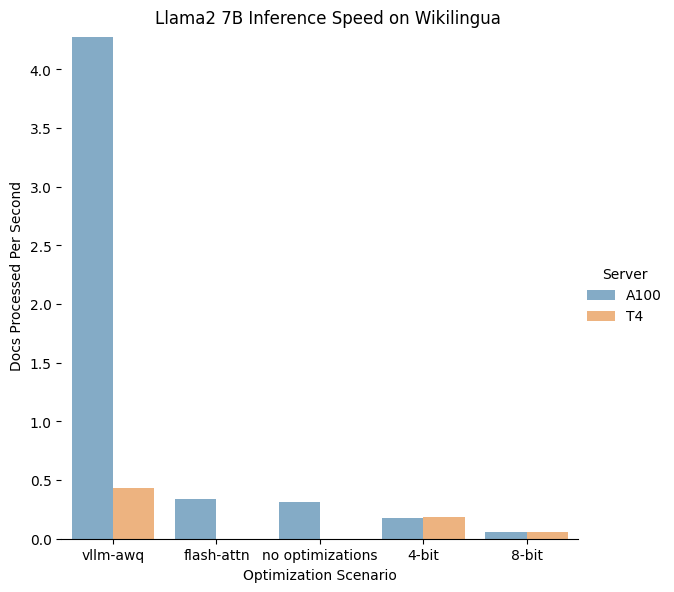

In [2]:
import seaborn as sns
import json
from collections import defaultdict

def read_json(path: str):
    with open(path) as f:
        return json.load(f)

data = defaultdict(list)
for exp in experiment_config:
    results = read_json("../" + exp["results_file"])
    data["avg_doc_per_sec"].append(results["avg_doc_per_sec"])
    data["server"].append(exp["server"])
    data["experiment_type"].append(exp["experiment_type"])

g = sns.catplot(
    data=data, kind="bar",
    x="experiment_type", y="avg_doc_per_sec", hue="server",
    errorbar="sd", alpha=.6, height=6
)
g.fig.suptitle("Llama2 7B Inference Speed on Wikilingua")
g.despine(left=True)
g.set_axis_labels("Optimization Scenario", "Docs Processed Per Second")
g.legend.set_title("Server")

## Interpretation

The use of [PagedAttention](https://arxiv.org/abs/2309.06180), automatic batching of inputs, quantization of model weights, CUDA execution graph utilization and CUDA kernel optimizations, amongst other techniques, set vLLM aside as the obvious winner in this experiment, particularly for the A100 GPU.

Other scenarios like [Flash Attention](https://arxiv.org/abs/2205.14135) or removal of optimizations were not possible to run on the T4 GPU due to memory constraints and out of memory errors when processing the 100 document dataset without truncation of inputs or decreasing generated output lengths.

For 4-bit and 8-bit quantization of the LLM, the T4 and A100 inference speed was roughly equal. These quantization techniques allowed the T4 GPU to finish generation of summaries by reducing the memory footprint of the model. 

Note that the 4-bit and 8-bit quantization experiments with the A100 were tested on a smaller subset of the data, but are included here for the main purpose of contextualizing the significant margin vLLM optimization leads by.

Another way to visualize this information is in the total time to generate summaries for 100 documents (including tokenization and loading):

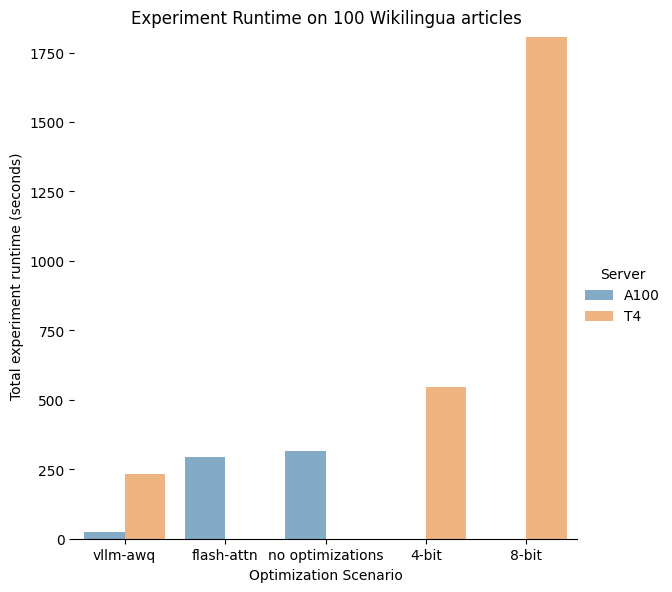

In [3]:
data = defaultdict(list)
for exp in experiment_config:
    if exp["experiment_number"] in (2, 4):
        # experiment run on smaller subset of data; skip
        continue
    results = read_json("../" + exp["results_file"])
    data["server"].append(exp["server"])
    data["experiment_type"].append(exp["experiment_type"])
    data["total_time"].append(results["total_time"])


g = sns.catplot(
    data=data, kind="bar",
    x="experiment_type", y="total_time", hue="server",
    errorbar="sd", alpha=.6, height=6
)
g.fig.suptitle("Experiment Runtime on 100 Wikilingua articles")
g.despine(left=True)
g.set_axis_labels("Optimization Scenario", "Total experiment runtime (seconds)")
g.legend.set_title("Server")

As seen above, the entire experiment runtime, accounting for tokenization, transfer of data to GPU, generation, and decoding, is significantly more time-intensive on the T4, particularly after quantization. 4-bit quantization dramatically speeds up the experiment compared to 8-bit, but the overally latency is still quite high compared to the vLLM T4 experiment or A100 experiments.

Since quantization and other optimizations discussed above can also impact quality, we look at the quality of the data these models produced next.

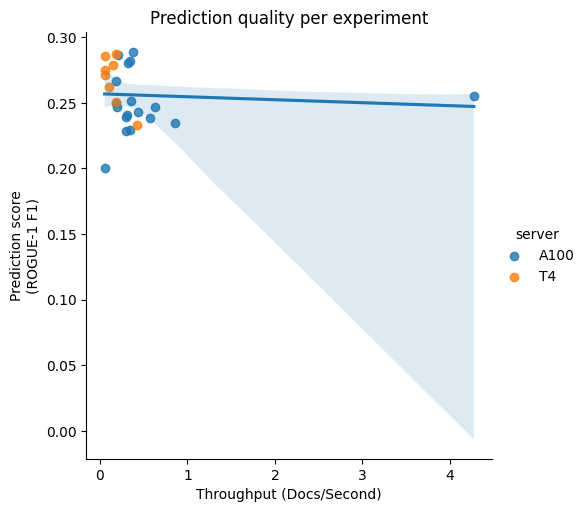

In [4]:
from pathlib import Path
import pandas as pd

data = defaultdict(list)
for results_file in Path("../data/").glob("results*.json"):
    if "_26_" in results_file.name:
        # Skip bogus results
        continue
    results = read_json(results_file)
    data["avg_doc_per_sec"].append(results["avg_doc_per_sec"])
    server = "A100" if "a100" in results_file.name.lower() else "T4"
    data["server"].append(server)
    data["pred_score"].append(results["pred_score"])

df = pd.DataFrame(data)
graph = sns.lmplot(x='avg_doc_per_sec', y='pred_score', hue='server', data=df, fit_reg=False)
ax = sns.regplot(x="avg_doc_per_sec", y="pred_score",
                data=df, scatter=False, ax=graph.axes[0, 0])
ax.set_xlabel("Throughput (Docs/Second)")
ax.set_ylabel("Prediction score\n(ROGUE-1 F1)")
ax.set_title('Prediction quality per experiment')
print()

Prediction quality was measured via by computing the [ROGUE-1](https://en.wikipedia.org/wiki/ROUGE_(metric))
F1 score for each example. The score is calculated by measuring the overlap of unigrams between the summaries
generated by the LLM with each corresponding ground truth summary from the Wikilingua dataset.

There appears to be a slight negative correlation between throughput and prediction quality, but the confidence
is very low as throughput increases, due to an outlier: the A100 vLLM experiment. There is not enough data, nor
are there enough optimization strategies to say with confidence that optimizations necessarily entail a decrease
in prediction quality, but certain optimization strategies such as 4-bit and 8-bit quantization of model weights
are known to decrease prediction quality by reducing the precision of floating point operations.

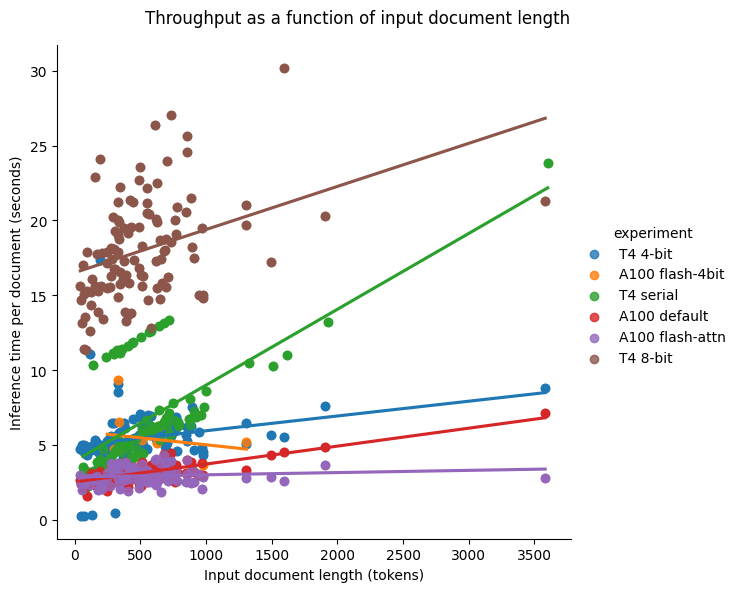

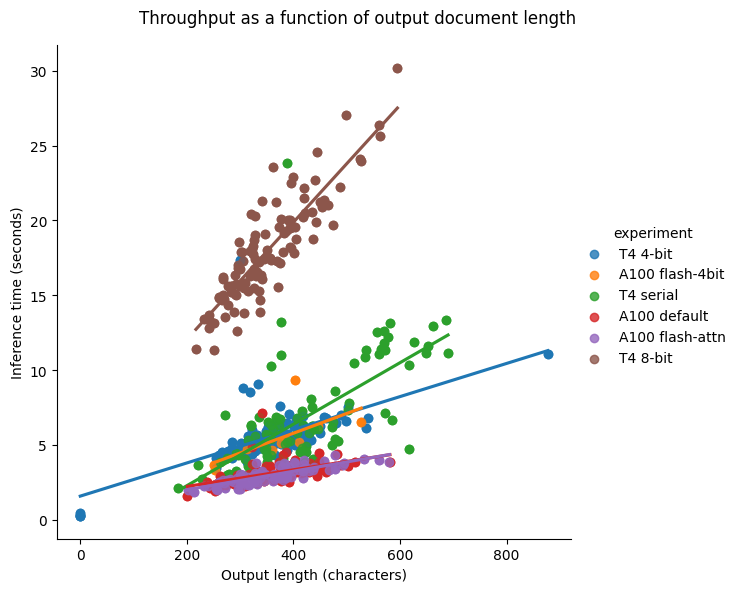

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt

data = defaultdict(list)
for data_file in Path("../data/").glob("data*.json"):
    records = read_json(data_file)
    server = "A100" if "a100" in data_file.name.lower() else "T4"
    experiment = data_file.stem.split("_")[-1]
    if "inference_time" in records[0] and "num_doc_tokens" in records[0]:
        for record in records:
            data["experiment"].append(f"{server} {experiment}")
            data["inference_time"].append(record["inference_time"])
            data["num_doc_tokens"].append(record["num_doc_tokens"])
            data["generated_chars"].append(len(record["pred_summary"]))



df = pd.DataFrame(data)
g = sns.FacetGrid(df, hue='experiment', height=6)
g.fig.suptitle("Throughput as a function of input document length")
g.map(plt.scatter, "num_doc_tokens", "inference_time")
g.map(sns.regplot, "num_doc_tokens", "inference_time", ci=None)
g.set_axis_labels("Input document length (tokens)", "Inference time per document (seconds)")
g.add_legend()
print()

g = sns.FacetGrid(df, hue='experiment', height=6)
g.fig.suptitle("Throughput as a function of output document length")
g.map(plt.scatter, "generated_chars", "inference_time")
g.map(sns.regplot, "generated_chars", "inference_time", ci=None)
g.set_axis_labels("Output length (characters)", "Inference time (seconds)")
g.add_legend()
print()

Generally, there was a positive correlation between inference speed and input document length
as well as speed and generated text length, the degree of which depended on the optimization
strategy. This is intuitive, since the longer a given input document (i.e. a Wikilingua article) is,
the greater the context that the LLM needs to process, which increases computational load on the server.
For Transformer LLMs like Llama2, the attention mechanism has to compute and keep track of attention
weights over a larger set of tokens due to the increased length of the prompt document.

For LLM output generation, computational load is also increased by the length of the output due to
the attention mechanism as well, which requires keeping a larger set of weights in memory over the
larger text. Also, since LLMs generate outputs in a sequence, token by token, the larger the total
generated text is, the longer the model needs to spend generating it.

For the experiments displayed above, Flash Attention appeared to be the most successful in
reducing inference time for increasingly longer texts.

## Memory and Other Issues

Quantization (e.g. 4-bit and 8-bit) significantly helped to prevent out of memory errors on the
T4 instance type. Memory issues were less of a concern on the larger-memory A100 until experiments with batching.
During the successful experiments, it was typical for T4 GPU memory
usage to be around 10-15GB, whereas A100 GPU memory usage was around 30-40GB.
There were many cases where the optimization techniques were insufficient to prevent an out of memory error on the GPU device.

The following table shows a variety of different errors from various experiments (note: on different documents):

| Scenario                 | GPU Type | Batch Size | Error                | Documents |
|--------------------------|----------|------------|----------------------|-----------|
| No optimizations         | `T4`     | 1          | `OutOfMemoryError`   | 10        |
| Flash Attention          | `T4`     | 1          | `RuntimeError`       | 10        |
| `default`                | `T4`     | 2          | `OutOfMemoryError`   | 10        |
| vLLM (no quantization)   | `T4`     | dynamic    | >90% prompts skipped | 100       |
|  No optimizations        | `A100`   | 4          | `OutOfMemoryError`   | 10        |
| Flash Attention          | `A100`   | 10         | `OutOfMemoryError`   | 100       |

Experiments that were unsuccessful due to high runtimes, skipped prompts, or memory issues on either the T4, the A100 or both include:

 - [DeepSpeed Optimizations](https://github.com/microsoft/DeepSpeed/tree/master/blogs/deepspeed-fastgen)
 - [DeepSpeed ZeRO-Inference](https://github.com/microsoft/DeepSpeedExamples/tree/master/inference/huggingface/zero_inference)
 - [IBM Foundation Model Stack](https://github.com/foundation-model-stack/foundation-model-stack)
 - [ONNX Inference](https://github.com/microsoft/Llama-2-Onnx)

The Flash Attention experiments were only run on the A100 GPU since it's incompatible with the T4 machine,
due to the T4 having an unsupported, older GPU type. Batching, meanwhile resulted in memory errors for all batch sizes (greater than 1) on the T4, and additionally occurred for all batches after 10 documents had been processed on the A100. This suggests that additional memory optimizations - likely of the sort included out-of-the-box in the vLLM library - are required to clear the memory. The above batching experiments used a naive approach of concatenating tensors of prompts based on a fixed batch size, whereas vLLM generates the batch sizes dynamically based on available memory and the total sequence lengths.


## Cost

Note that using the A100 requires a Colab Pro subscription, and eats up about 2 credits per hour.
Additionally, after a certain amount of time using the free T4, Colab pre-empted experiment
sessions in faver of paying customers. The most expensive part of this experiment was
collecting baseline benchmarks on non-optimized models, since they take the longest to run.

All in all, this experiment costed `$20.00` to run (200 credits at `$10.00` per 100 credits).